# 0. Imports


In [3]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

# 1. O Problema

## 1.1 O que é League of legends

**League of Legends** (abreviado como **LoL** e comumente referido como League) é um jogo
eletrônico do gênero multiplayer online battle arena (MOBA) desenvolvido e publicado pela Riot
Games.


No jogo, duas equipes de cinco jogadores batalham em um combate jogador contra jogador
(PvP), com cada equipe ocupando e defendendo sua metade do mapa. Cada um dos dez
jogadores controla um personagem, conhecido como "campeão", com habilidades únicas e
diferentes estilos de jogo. Durante uma partida, os campeões se tornam mais poderosos ao
coletarem pontos de experiência, ganharem ouro e comprarem itens a fim de derrotar a equipe
adversária. No modo principal, Summoner's Rift, o objetivo primário é avançar até a base
inimiga e destruir uma grande estrutura localizada em seu centro, sob o nome de "Nexus

## 1.2 Desafio

**Objetivo:**
Atualmente o Lol conta com 162 personagens disponiveis para escolha. Enquanto jogamos ou assistimos aos outros jogarem fica evidente que em alguns casos alguns personagens tem vantagens sobre os outros. Mas e se conseguissimos determinar qual a melhor escolha possível de forma a otimizar sua chace de vencer um jogo?

O objetivo neste trabalho é criar um modelo que indique os campeões que maximizem a chance de um time vencer após a definição das outras 9 escolhas.

O verdadeito game changer.

**Planejamento da solução**

- Analisar a viabilidade do modelo a partir de dados passados, ou seja com todas as informações que aocnteceram em uma partida
- Criar bases auxiliares com estetisticas dos personagens para que possomos criar um modelo a partir apenas dos personagens e alimentando com essas informações auxiliares (observação: Essa base deve conter apenas informações da base treino)
- Refazer o treinamento do modelo 1 com as novas indicações de estatisticas
- Modelo de regressão
- Métricas
    - F1-score




# 2. Fonte de dados

## 2.1 Extração API

O league of legends tem uma API própia para aqueles que desejam analisar os dados das partidas.

A API pdoe ser acessada pelo site https://developer.riotgames.com/

Neste trabalho foi necessário renovar a key toda a vez que era necessário uma extração de dados, porêm é possível solicitar uma key permanente, mas isso leva algum tempo, e não foi possível usa-la para este trabalho.

Por essse motivo o script de extração de dados foi executado na máquina local, extraindo dados das partidas dos 200 melhores jogadores da região do Brasil.

O script pode ser encontrado no githhub: **Colocar link aqui**

## 2.2 Carregando os dados

In [4]:
role = get_execution_role()
bucket='projeto-interdisciplinar'
data_key = 'partidas_detalhadas.xlsx'
data_location = 's3://{}/{}'.format(bucket, data_key)


In [3]:
base = pd.read_excel(data_location)

In [7]:
base.head()

,Partida,Tempo,Blue Team Victory,champion_id_Top_blue_side,champion_Top_blue_side,kill_Top_blue_side,death_Top_blue_side,assist_Top_blue_side,damage_per_minute_Top_blue_side,gold_per_minute_Top_blue_side,...,gold_per_minute_Adc_red_side,vision_per_minute_Adc_red_side,champion_id_Sup_red_side,champion_Sup_red_side,kill_Sup_red_side,death_Sup_red_side,assist_Sup_red_side,damage_per_minute_Sup_red_side,gold_per_minute_Sup_red_side,vision_per_minute_Sup_red_side
0,BR1_2607889462,32.950000,False,266,Aatrox,0,1,6,440.169051,390.094271,...,424.966404,1.226336,104.0,Graves,2.0,5.0,2.0,454.543289,375.587076,3.715915
1,BR1_2607868377,17.466667,False,84,Akali,6,3,0,640.653606,437.823471,...,612.495282,0.466930,412.0,Thresh,1.0,1.0,13.0,232.126795,306.794212,1.136832
2,BR1_2607843393,16.750000,False,164,Camille,2,4,4,452.764237,375.834466,...,623.614783,0.413094,25.0,Morgana,2.0,1.0,19.0,297.290379,373.592809,1.283953
3,BR1_2607796695,29.033333,True,164,Camille,6,4,3,688.090085,408.784779,...,463.537844,0.627343,497.0,Rakan,2.0,5.0,7.0,183.642915,247.911209,2.497650
4,BR1_2607756218,26.400000,True,157,Yasuo,7,0,10,601.782848,549.118970,...,331.528842,0.905511,24.0,Jax,2.0,4.0,0.0,385.149768,342.278600,1.018867


## 2.3 Estrutura dos dados

In [8]:
# como existem alguns dados nulos vamos remove-los para evitar ruidos já que são poucos. Isso não irá afetar nosso modelo final 
base.dropna(inplace=True)

In [9]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35309 entries, 0 to 35324
Data columns (total 83 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Partida                             35309 non-null  object 
 1   Tempo                               35309 non-null  float64
 2   Blue Team Victory                   35309 non-null  bool   
 3   champion_id_Top_blue_side           35309 non-null  int64  
 4   champion_Top_blue_side              35309 non-null  object 
 5   kill_Top_blue_side                  35309 non-null  int64  
 6   death_Top_blue_side                 35309 non-null  int64  
 7   assist_Top_blue_side                35309 non-null  int64  
 8   damage_per_minute_Top_blue_side     35309 non-null  float64
 9   gold_per_minute_Top_blue_side       35309 non-null  float64
 10  vision_per_minute_Top_blue_side     35309 non-null  float64
 11  champion_id_Jungle_blue_side        35309

Apesar da grande qauntidade de features, podemos resumir as 83 colunas em 11 tipos:

- Partida : Código da partida, irrelevante para análise e será retirado na hora da análise

- Tempo : Duração da partida                         

- Blue Team Victory : Indica a vitória ou derrota do time do lado azul

- champion_id_{**Posição**}_{**Time**}_side : Código do campeão escolhido pelo time na posição

- champion_{**Posição**}_{**Time**}_side: Nome do campeão escolhido pelo time na posição

- kill_{**Posição**}_{**Time**}_side: Abates do campeão escolhido pelo time na posição

- death_{**Posição**}_{**Time**}_side: Mortes do campeão escolhido pelo time na posição

- assist_{**Posição**}_{**Time**}_side: Assistências do campeão escolhido pelo time na posição

- damage_per_minute_{**Posição**}_{**Time**}_side: Dano por minuto do campeão escolhido pelo time na posição

- gold_per_minute_{**Posição**}_{**Time**}_side: Ouro ganho por minuto do campeão escolhido pelo time na posição

- vision_per_minute_{**Posição**}_{**Time**}_side: Ouro ganho por minuto do campeão escolhido pelo time na posição


## 2.4 Pré vizualização

In [15]:
posicao = [ "Top", "Jungle", "Mid", "Adc", "Sup"]
times = ["red", 'blue']

In [4]:
def display_analise(posicao, time):
    colunas = [ f'kill_{posicao}_{time}_side',
                f'death_{posicao}_{time}_side',
                f'assist_{posicao}_{time}_side',
                f'damage_per_minute_{posicao}_{time}_side',
                f'gold_per_minute_{posicao}_{time}_side',
                f'vision_per_minute_{posicao}_{time}_side']
    base_aux = base[colunas]
    base_aux.hist(bins=50, figsize=(20,15),color = time)
    display()

In [ ]:
for posi in posicao:
    for team in times:
        display_analise(posi, team)

## 2.5 Treino e teste

Checando por dados duplicados

In [13]:
base.duplicated().any()

True

In [14]:
len(base["Partida"].unique())

27477

In [15]:
base = base.drop_duplicates()

In [16]:
base.duplicated().any()

False

Ao analisar os dados podemos ver que a feature de visão por minuto apresenta um comportamento estranho próximo ao 0, por enquanto amnteremos esse dado assim, caso necessário após alguns testes podemos fazer algo a respeito disso.

**Amostras**

In [17]:
#Vamos remover a coluna que indica a partida
base.drop("Partida", axis = 1 , inplace = True)

In [18]:
base.reset_index(inplace= True, drop = True)

In [19]:
base["Blue Team Victory"] = base["Blue Team Victory"].astype(int)

In [20]:
#Removendo os códigos dos campeões
for posi in posicao:
    for team in times:
        base.drop(f"champion_id_{posi}_{team}_side", axis = 1 , inplace = True)

In [21]:
from sklearn.model_selection import train_test_split

base_train, base_test = train_test_split(base, test_size=0.2, stratify=base['Blue Team Victory'], random_state=42)

In [22]:

base_test.shape

(5496, 72)

In [23]:
base_train.shape

(21981, 72)

**Salvando as bases de treino e teste**

In [24]:
base_train.to_excel('s3://{}/{}'.format(bucket, "treino.xlsx"), index = False)

In [25]:
base_test.to_excel('s3://{}/{}'.format(bucket, "teste.xlsx"), index = False)

In [5]:
base_train = pd.read_excel('s3://{}/{}'.format(bucket, "treino.xlsx"))
base_test = pd.read_excel('s3://{}/{}'.format(bucket, "teste.xlsx"))

# 4. Explorando os dados

Correlação

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [27]:
base_train.corr()["Blue Team Victory"].sort_values(ascending=False)

Blue Team Victory                   1.000000
death_Jungle_red_side               0.401020
assist_Sup_blue_side                0.391659
gold_per_minute_Jungle_blue_side    0.371917
death_Adc_red_side                  0.356042
                                      ...   
death_Mid_blue_side                -0.335401
death_Sup_blue_side                -0.340332
death_Adc_blue_side                -0.353507
assist_Sup_red_side                -0.385561
death_Jungle_blue_side             -0.398823
Name: Blue Team Victory, Length: 62, dtype: float64

# 5. Preparando os dados

## 5.1 Separando o target do resto

In [7]:
# separando o target do resto
base_train_pre = base_train.drop(columns=['Blue Team Victory'])
base_train_target = base_train['Blue Team Victory'].copy()

## 5.2 Separando Variáveis categóricas do resto

In [10]:
# categorical
categorical = []
for posi in posicao:
    for team in times:
        categorical.append(f"champion_{posi}_{team}_side")


# numerical atributes
num_attributes = base_train_pre.columns.drop(categorical)
#num_attributes = base_train_pre.columns.drop("Tempo")

# separating the features
base_train_pre_num = base_train_pre[num_attributes]
base_train_pre_cat = base_train_pre[categorical]

## 5.3 Pipeline

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])


cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # as the categories are numbers, we can use the SimpleImputer
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])


# (name, transformer, columns)
preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_attributes),
    ('categorical', cat_pipeline, categorical)
])

# 6. Seleção de modelos inicial

In [12]:
X_train = preprocessed_pipeline.fit_transform(base_train_pre)
X_train.shape

(21981, 1680)

In [13]:
y_train = base_train_target

In [8]:
# printing function
import statistics
def display_scores(scores):
    print("Scores:", scores)
    try:
        print("\nMean:", scores.mean())
        print("Standard deviation:", scores.std())
    except:
        print("\nMean:", statistics.mean(scores))
        print("Standard deviation:", statistics.stdev(scores))

## 6.1 Modelos classificadores

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
from sklearn.model_selection import cross_val_score , cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

### 6.1.1 KNN

In [30]:
knn = KNeighborsClassifier()  # C=1.0, loss='squared hinge'
knn_accs = cross_val_score(knn, X_train, y_train, scoring="f1", cv=20)

display_scores(knn_accs)

Scores: [0.92769953 0.93040991 0.92850511 0.93432007 0.91856061 0.92565056
 0.92336802 0.92307692 0.93080569 0.91825095 0.91115312 0.91346154
 0.93142857 0.93457944 0.92775665 0.9273743  0.92205323 0.91753555
 0.93506494 0.92509363]

Mean: 0.9253074170816186
Standard deviation: 0.006701620729891724


### 6.1.2 SVC

In [29]:
svc = SVC()  # C=1.0, loss='squared hinge'
svc_accs = cross_val_score(svc, X_train, y_train, scoring="f1", cv=20)

display_scores(svc_accs)

Scores: [0.96545285 0.97282099 0.97191011 0.97378277 0.96707432 0.97089202
 0.96986817 0.96635514 0.97744361 0.95692884 0.96545285 0.95798319
 0.95970009 0.96525822 0.97276995 0.96089385 0.96525822 0.96310312
 0.96913003 0.96157451]

Mean: 0.9666826427954474
Standard deviation: 0.0054838860441932735


### 6.1.3 LinearSVC

In [31]:
model = LinearSVC()  # C=1.0, loss='squared hinge'
model_accs = cross_val_score(model, X_train, y_train, scoring="f1", cv=20)

display_scores(model_accs)

Scores: [0.96499527 0.97191011 0.96512724 0.96713615 0.97940075 0.96261682
 0.96506138 0.9587242  0.9587242  0.9587242  0.96338028 0.95112782
 0.96219282 0.96992481 0.96499527 0.95042095 0.94835681 0.96387833
 0.96338028 0.95700935]

Mean: 0.9623543522201373
Standard deviation: 0.007169495490405395


### 6.1.4 NuSVC

In [32]:
model = NuSVC()  
model_accs = cross_val_score(model, X_train, y_train, scoring="f1", cv=20)

display_scores(model_accs)

Scores: [0.94336119 0.94418165 0.93930906 0.94444444 0.9382716  0.94150418
 0.94207028 0.942723   0.94528302 0.93521127 0.94018692 0.92048644
 0.94062205 0.95291902 0.94657919 0.94357077 0.94050992 0.94486692
 0.93996248 0.93984962]

Mean: 0.9412956505306387
Standard deviation: 0.005963817023057425


### 6.1.5 DecisionTreeClassifier

In [33]:
model = DecisionTreeClassifier()  
model_accs = cross_val_score(model, X_train, y_train, scoring="f1", cv=20)

display_scores(model_accs)

Scores: [0.87028519 0.87164751 0.8531856  0.86245353 0.86592179 0.87453184
 0.86171214 0.88059701 0.85956645 0.8547486  0.85983067 0.84030418
 0.86544046 0.86931818 0.87255814 0.85793872 0.85714286 0.85416667
 0.86915888 0.86792453]

Mean: 0.863421646723641
Standard deviation: 0.008989267541452144


### 6.1.6 RandomForestClassifier

In [34]:
model = RandomForestClassifier()  
model_accs = cross_val_score(model, X_train, y_train, scoring="f1", cv=20)

display_scores(model_accs)

Scores: [0.95416277 0.94646272 0.93533271 0.94413408 0.94817658 0.94428706
 0.93333333 0.9388523  0.93726236 0.93472091 0.94106464 0.93132643
 0.93950851 0.95184136 0.9535545  0.9354537  0.94117647 0.94207028
 0.95265152 0.94128788]

Mean: 0.942333004923038
Standard deviation: 0.006809309184349222


### 6.1.7 AdaBoostClassifier

In [35]:
model = AdaBoostClassifier()  
model_accs = cross_val_score(model, X_train, y_train, scoring="f1", cv=20)

display_scores(model_accs)

Scores: [0.94007491 0.95103578 0.93560606 0.93196645 0.94423792 0.93445693
 0.93207547 0.93395349 0.92843691 0.93370682 0.93472091 0.92987512
 0.93862134 0.943074   0.93791786 0.93933824 0.92883895 0.9370229
 0.93408663 0.94052045]

Mean: 0.936478356420435
Standard deviation: 0.005450361761507367


### 6.1.8 GradientBoostingClassifier

In [36]:
model = GradientBoostingClassifier()  
model_accs = cross_val_score(model, X_train, y_train, scoring="f1", cv=20)

display_scores(model_accs)

Scores: [0.95586854 0.96506138 0.94924812 0.95813953 0.94706994 0.96344892
 0.94706994 0.95708955 0.9472693  0.94953271 0.95931883 0.9462771
 0.94995279 0.95463138 0.94995279 0.95255814 0.94806421 0.95364238
 0.96233522 0.94360902]

Mean: 0.9530069901224051
Standard deviation: 0.006090806382000204


## 6.2 Regressores

In [67]:
pip install  lightgbm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.1 MB/s eta 0:00:00:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
#from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [64]:
def arredonda(num):
    if num > 0.51:
        return 1
    else:
        return 0
    
def treino_modelos(clf):
    y_train_teste = y_train.values
    X_train_teste = X_train.toarray()
    cv = KFold(n_splits=20 ,shuffle = True)
    
    lst_f1 = []
    i=1
    for train_index, test_index in cv.split(X_train_teste,y_train_teste):
        print(i)
        x_train_fold, x_test_fold = X_train_teste[train_index], X_train_teste[test_index]
        y_train_fold, y_test_fold = y_train_teste[train_index], y_train_teste[test_index]
        #print( len(train_index ),len(test_index),len(x_train_fold ),len(x_test_fold ),len(y_train_fold ),len(y_test_fold ))
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        preds = [arredonda(num) for num in preds]
        lst_f1.append(f1_score(y_test_fold, preds, zero_division=1))
        i+=1
    display_scores(lst_f1)

### 6.2.1 Regressor logistico

In [94]:
clf = LogisticRegression()
treino_modelos(clf)

Scores: [0.9766136576239476, 0.9696969696969696, 0.9695238095238096, 0.9610894941634242, 0.9602954755309325, 0.9770723104056438, 0.9689922480620154, 0.9830827067669171, 0.9690309690309691, 0.9736123748862602, 0.9704480457578646, 0.9703153988868276, 0.9703504043126685, 0.9724770642201834, 0.9754178957718781, 0.9688715953307393, 0.974074074074074, 0.9714285714285715, 0.983050847457627, 0.9693023255813953]

Mean: 0.971737311925636
Standard deviation: 0.005712790558103677


### 6.2.2 Regressor de Árvore de decisão 

In [24]:
clf = DecisionTreeRegressor()
treino_modelos(clf)

Scores: [0.8785046728971962, 0.8764867337602927, 0.8703007518796992, 0.849624060150376, 0.8595194085027726, 0.8602362204724409, 0.8616600790513833, 0.8493919550982226, 0.8294062205466541, 0.8612716763005781, 0.8630783758262511, 0.8472095150960658, 0.8595988538681949, 0.8592730661696178, 0.86219739292365, 0.8670944087992667, 0.8568824065633546, 0.870822041553749, 0.8444863336475024, 0.8706099815157117]

Mean: 0.8598827077311489
Standard deviation: 0.011675206465577964


### 6.2.3 Regressão Linear

In [31]:
clf = LinearRegression()
treino_modelos(clf)

Scores: [0.9526515151515151, 0.9467680608365018, 0.9583736689254598, 0.9520225776105361, 0.9586140519730509, 0.962671905697446, 0.9396226415094339, 0.9468503937007874, 0.9527272727272726, 0.9603864734299516, 0.9585172109443953, 0.9468779123951537, 0.9467680608365019, 0.9533582089552239, 0.9417293233082706, 0.9489322191272053, 0.9519230769230769, 0.952734012974977, 0.9580952380952381, 0.9488117001828154]

Mean: 0.9519217762652407
Standard deviation: 0.006228971801186495


### 6.2.4 Adaboost Regressor

In [35]:
clf = AdaBoostRegressor()
treino_modelos(clf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Scores: [0.9079422382671481, 0.9206349206349207, 0.9192546583850931, 0.9089301503094607, 0.9102333931777379, 0.904363974001857, 0.9001814882032668, 0.8984156570363466, 0.9169000933706816, 0.8959537572254336, 0.9057301293900185, 0.8920863309352518, 0.9092558983666063, 0.9105691056910568, 0.9035812672176308, 0.9052437902483902, 0.9033457249070631, 0.9090909090909092, 0.9050387596899225, 0.9188156638013371]

Mean: 0.9072783954975067
Standard deviation: 0.007659120681065911


### 6.2.5 Gradiente Boosting Regressor

In [37]:
clf = GradientBoostingRegressor()
treino_modelos(clf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Scores: [0.9350145489815712, 0.9622641509433963, 0.9448529411764707, 0.9434306569343065, 0.9371428571428572, 0.9366336633663366, 0.9402546523016649, 0.9274809160305343, 0.9399428026692088, 0.9433962264150944, 0.9353049907578558, 0.9517625231910946, 0.9509713228492138, 0.9366130558183537, 0.9307116104868914, 0.944015444015444, 0.9362101313320825, 0.9368029739776952, 0.9474671669793622, 0.95311004784689]

Mean: 0.9416691341608162
Standard deviation: 0.008381772826467526


### 6.2.6  XgBoost

In [28]:
clf = XGBRegressor()
treino_modelos(clf)

Scores: [0.94257064721969, 0.9557021677662583, 0.9419354838709678, 0.9494020239190433, 0.943798449612403, 0.9374416433239963, 0.9514747859181732, 0.9408341416100873, 0.9396226415094339, 0.9486510008703221, 0.9509366636931311, 0.9474671669793621, 0.9458413926499033, 0.9436893203883495, 0.9508196721311475, 0.9401869158878503, 0.9462809917355373, 0.951035781544256, 0.9521126760563381, 0.9377431906614786]

Mean: 0.9458773378673865
Standard deviation: 0.005311469234681345


### 6.2.7  LightXgBoost

In [31]:
clf = LGBMRegressor()
treino_modelos(clf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Scores: [0.9568480300187617, 0.9705882352941176, 0.9560336763330215, 0.9589552238805971, 0.9497098646034815, 0.9446064139941691, 0.9602272727272728, 0.9527559055118111, 0.9440879926672776, 0.9439696106362773, 0.9481915933528836, 0.9543795620437956, 0.9558823529411764, 0.9446564885496184, 0.9566929133858267, 0.9572338489535941, 0.9484936831875607, 0.9569990850869168, 0.9442870632672332, 0.9571694599627559]

Mean: 0.9530884138199074
Standard deviation: 0.006986134635588862


### 6.2.8  BayesianRidge

In [ ]:
clf = BayesianRidge()
treino_modelos(clf)

1
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Scores: [0.972972972972973, 0.9602272727272728, 0.9586776859504132, 0.9745454545454546, 0.9521912350597609, 0.9599271402550091, 0.955223880597015, 0.9549218031278749, 0.9514370664023786, 0.9602220166512488, 0.9603024574669187, 0.960573476702509, 0.9620253164556962, 0.9658536585365853, 0.9537299338999056, 0.9531405782652044, 0.9611111111111111, 0.9591642924976258, 0.9642512077294686, 0.9625570776255709]

Mean: 0.9601527819289999
Standard deviation: 0.006138119045365233


## 6.3 Modelos selecionados

Pudemos observar que a maioria dos modelos apresenta um score médio de 0.95, porêm devemos levar em consideração que para o sistema de recomendação planejado é necessário um moidelo que nos forneça um resutlado continuo entre 0 e 1. Sendo assim os classificadores estão eliminados.
O Modelo de regressão logistica apensar de ser um classificador binário pretendiamos usa-lo a partir das probabilidades fornecidas, mas não houve tempo de seguir por este caminho portanto também foi eliminado.
Dos modelos restantes vamos escolher os que obtiveram melhores médias de score:
- **BayesianRidge**
- **LightXgBoost**

Agora precisamos generalizar os dados, ou seja, as colunas de dano, ouro, visão, etc deve ser obtidas a aprtid da média do campeão usado.
Para isso vamos vafzer uma nova divisão dos dados de treino em treino e teste e a partir disso desenvolver uma base auxiliar para consultas

# 7. Generalização 

## 7.1 Base aulixiar

**Tentar criar a tabela auxiliarpensndo em quem é o adversário**

In [11]:
from sklearn.model_selection import train_test_split


In [10]:
base_train = pd.read_excel('s3://{}/{}'.format(bucket, "treino.xlsx"))

In [13]:
base_train_final, base_test_final = train_test_split(base_train, test_size=0.2, stratify=base_train['Blue Team Victory'], random_state=42)

In [26]:
def analise_auxiliar(posicao, time, campeao,base_train_final):
    dicionario = {}
    dicionario["campeao"] = campeao
    dicionario["time"] = time
    dicionario["posicao"] = posicao
    dicionario["kill"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'kill_{posicao}_{time}_side'])
    dicionario["death"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'death_{posicao}_{time}_side'])
    dicionario["assist"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'assist_{posicao}_{time}_side'])
    dicionario["dano"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'damage_per_minute_{posicao}_{time}_side'])
    dicionario["ouro"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'gold_per_minute_{posicao}_{time}_side'])
    dicionario["visao"] = statistics.mean(base_train_final.loc[base_train_final[f'champion_{posi}_{team}_side'] == campeao,   f'vision_per_minute_{posicao}_{time}_side'])
    return dicionario


In [30]:
lista_auxiliar = []
for posi in posicao:
    for team in times:
        for campeao in base_train_final[f'champion_{posi}_{team}_side'].unique():
            lista_auxiliar.append(analise_auxiliar(posi, team, campeao,base_train_final))
            
 
aux_exploratorio = pd.DataFrame(lista_auxiliar)

In [35]:
def busca_aux(time, posicao, campeao, feature):
    return aux_exploratorio.loc[(aux_exploratorio["campeao"] == campeao) & (aux_exploratorio["time"] == time) & (aux_exploratorio["posicao"] == posicao),feature].values[0]

In [40]:
for posi in posicao:
    for team in times:
        base_train_final[ f'kill_{posi}_{team}_side'] = base_train_final.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"kill"),axis = 1)
        base_train_final[f'death_{posi}_{team}_side'] = base_train_final.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"death"),axis = 1)
        base_train_final[f'assist_{posi}_{team}_side'] = base_train_final.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"assist"),axis = 1)
        base_train_final[f'damage_per_minute_{posi}_{team}_side'] = base_train_final.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"dano"),axis = 1)
        base_train_final[f'gold_per_minute_{posi}_{team}_side'] = base_train_final.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"ouro"),axis = 1)
        base_train_final[f'vision_per_minute_{posi}_{team}_side'] = base_train_final.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"visao"),axis = 1)

## 7.2 Pipeline

In [42]:
# separando o target do resto
base_train_pre = base_train_final.drop(columns=['Blue Team Victory'])
base_train_target = base_train_final['Blue Team Victory'].copy()

In [46]:
base_train_pre

,Tempo,champion_Top_blue_side,kill_Top_blue_side,death_Top_blue_side,assist_Top_blue_side,damage_per_minute_Top_blue_side,gold_per_minute_Top_blue_side,vision_per_minute_Top_blue_side,champion_Jungle_blue_side,kill_Jungle_blue_side,...,damage_per_minute_Adc_red_side,gold_per_minute_Adc_red_side,vision_per_minute_Adc_red_side,champion_Sup_red_side,kill_Sup_red_side,death_Sup_red_side,assist_Sup_red_side,damage_per_minute_Sup_red_side,gold_per_minute_Sup_red_side,vision_per_minute_Sup_red_side
10112,26.483333,Aatrox,5.162775,5.013049,5.400412,698.103123,419.758708,0.716642,Kayn,7.912773,...,690.235088,498.657235,0.829964,Taric,1.664336,5.444056,14.846154,238.254842,298.282339,1.763996
2669,31.100000,Tryndamere,5.696970,4.375758,4.254545,612.828915,470.759573,0.685519,Kindred,7.812987,...,672.850183,490.777056,0.493654,Singed,2.666667,7.416667,11.583333,406.277997,373.191182,1.160130
4786,32.616667,Riven,6.230072,5.697464,5.056159,648.298310,433.811667,0.706489,Kindred,7.812987,...,650.204152,453.273969,0.668399,Karma,2.450609,5.420839,13.622463,429.467701,310.321287,2.121050
2097,24.066667,Ornn,3.000000,4.420690,8.565517,535.207496,371.202623,0.613090,LeeSin,7.489440,...,744.308436,458.793079,0.704246,Thresh,1.601093,5.561020,14.881603,250.478926,291.050098,1.848744
12540,20.400000,TahmKench,4.307692,5.782051,10.525641,646.066779,394.700474,0.563036,Qiyana,9.180328,...,863.987226,506.394345,0.326195,LeeSin,9.511111,7.911111,15.088889,973.820626,589.447313,0.474364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12266,25.850000,Fiora,5.310827,5.324796,4.481956,687.249773,421.490141,0.687646,Graves,6.868362,...,846.838436,439.868625,0.639034,Sona,2.189630,5.050370,14.440000,340.469242,303.231383,1.863283
19197,29.950000,Aatrox,5.162775,5.013049,5.400412,698.103123,419.758708,0.716642,Kayn,7.912773,...,808.981632,458.544341,0.665458,Senna,4.261456,6.115903,13.229111,604.519455,379.778006,2.071971
15260,29.566667,Aatrox,5.162775,5.013049,5.400412,698.103123,419.758708,0.716642,Nunu,4.523077,...,713.395366,454.937689,0.801932,Lux,3.752418,5.675048,13.214700,584.699852,356.163685,1.780478
6953,33.783333,Jax,5.213501,5.152276,4.130298,636.631361,424.607243,0.625879,Graves,6.868362,...,702.670432,458.525542,0.759202,Amumu,2.171123,7.418895,13.245989,316.480145,289.382624,1.831621


In [49]:
# categorical
categorical = []
for posi in posicao:
    for team in times:
        categorical.append(f"champion_{posi}_{team}_side")


# numerical atributes
num_attributes = base_train_pre.columns.drop(categorical ,"Tempo" )
#num_attributes = num_attributes.columns.drop("Tempo")

# separating the features
base_train_pre_num = base_train_pre[num_attributes]
base_train_pre_cat = base_train_pre[categorical]

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('robust_scaler', RobustScaler())
])


cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # as the categories are numbers, we can use the SimpleImputer
    ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore'))
])


# (name, transformer, columns)
preprocessed_pipeline = ColumnTransformer([
    ('numerical', num_pipeline, num_attributes),
    ('categorical', cat_pipeline, categorical)
])

In [58]:
X_train = preprocessed_pipeline.fit_transform(base_train_pre)
X_train.shape

(17584, 1680)

In [74]:
y_train = base_train_target

Transformando os dados de teste

In [75]:
base_test_pre = base_test_final.drop(columns=['Blue Team Victory'])
base_test_target = base_test_final['Blue Team Victory'].copy()

X_test = preprocessed_pipeline.transform(base_test_pre).toarray()
y_test = base_test_target.values

## 7.3 Testando os modelos

In [79]:
def teste_final (clf):
    y_train_teste = y_train
    X_train_teste = X_train.toarray()
    clf.fit(X_train_teste,y_train_teste)
    preds = clf.predict(X_test)
    preds = [arredonda(num) for num in preds]
    print(f1_score(y_test, preds, zero_division=1))

### 7.3.1 BayesianRidge

In [80]:
clf = BayesianRidge()
teste_final(clf)

17584 17584
0.9216286184984703


### 7.3.2 LGBMRegressor

In [81]:
clf = LGBMRegressor()
teste_final(clf)

17584 17584
0.6664866324601675


# 8. Otimização de Parâmetros
Tendo em vista a parca de desempenho do LGBM, vamos segui apenas com o último modelo BayesianRidge

Como estamos usando um modelo não binário fica impossibilidado o uso do searchgrid, portanto vamos implementar isso na mão.

In [85]:
model = BayesianRidge()
parameters = {'n_iter' : [300,  700,  1200],
              'compute_score' : [True, False],
              'fit_intercept' : [True, False],
              'normalize' : [True, False],
              'verbose' : [True, False],
                 }

In [92]:
def otimizacao_parametros (alfa , inter, comp,fit,norma,verbose):
    aux = { 'n_iter' : inter,
            'compute_score' : comp,
            'fit_intercept' : fit,
            'normalize' : norma,
            'verbose' : verbose}
    
    model = BayesianRidge(  n_iter = inter,
                            compute_score = comp,
                            fit_intercept = fit,
                            normalize = norma,
                            verbose = verbose)
    y_train_teste = y_train
    X_train_teste = X_train.toarray()
    model.fit(X_train_teste,y_train_teste)
    preds = model.predict(X_test)
    preds = [arredonda(num) for num in preds]
    aux["f1"] = f1_score(y_test, preds, zero_division=1)
    print(f1_score(y_test, preds, zero_division=1))
    return aux
    

In [93]:
lista = []
i = 1
for inter in parameters['n_iter']:
    print(i)
    i+=1
    for comp in parameters['compute_score']:
        for fit in parameters['fit_intercept']:
            for norma in parameters['normalize']:
                for verbose in parameters['verbose']:
                    lista.append(otimizacao_parametros (alfa , inter, comp,fit,norma,verbose))

1
Convergence after  50  iterations
0.6008531383302864
0.6008531383302864
Convergence after  27  iterations
0.9216286184984703
0.9216286184984703
Convergence after  10  iterations
0.8811607554122524
0.8811607554122524
Convergence after  10  iterations
0.8811607554122524
0.8811607554122524
Convergence after  50  iterations
0.6008531383302864
0.6008531383302864
Convergence after  27  iterations
0.9216286184984703
0.9216286184984703
Convergence after  10  iterations
0.8811607554122524
0.8811607554122524
Convergence after  10  iterations
0.8811607554122524
0.8811607554122524
2
Convergence after  50  iterations
0.6008531383302864
0.6008531383302864
Convergence after  27  iterations
0.9216286184984703
0.9216286184984703
Convergence after  10  iterations
0.8811607554122524
0.8811607554122524
Convergence after  10  iterations
0.8811607554122524
0.8811607554122524
Convergence after  50  iterations
0.6008531383302864
0.6008531383302864
Convergence after  27  iterations
0.9216286184984703
0.92162

# 9. Modelo Final

Apesar da busca para a otimização dos hyperparametros, nenhum dos usados foi efetivo, ou seja iremos utilizar o modelo padrão.

In [95]:
# leitura das bases separadas inicialmente
base_train = pd.read_excel('s3://{}/{}'.format(bucket, "treino.xlsx"))
base_test = pd.read_excel('s3://{}/{}'.format(bucket, "teste.xlsx"))

In [97]:
#Separação do target 
base_train_pre = base_train.drop(columns=['Blue Team Victory'])
base_train_target = base_train['Blue Team Victory'].copy()

In [98]:
# Criação da nova base auxiliar 
lista_auxiliar = []
for posi in posicao:
    for team in times:
        for campeao in base_train_pre[f'champion_{posi}_{team}_side'].unique():
            lista_auxiliar.append(analise_auxiliar(posi, team, campeao,base_train_pre))
            

aux_exploratorio = pd.DataFrame(lista_auxiliar)

In [101]:
#Transformando so dados de treino
for posi in posicao:
    for team in times:
        base_train_pre[ f'kill_{posi}_{team}_side'] = base_train_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"kill"),axis = 1)
        base_train_pre[f'death_{posi}_{team}_side'] = base_train_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"death"),axis = 1)
        base_train_pre[f'assist_{posi}_{team}_side'] = base_train_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"assist"),axis = 1)
        base_train_pre[f'damage_per_minute_{posi}_{team}_side'] = base_train_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"dano"),axis = 1)
        base_train_pre[f'gold_per_minute_{posi}_{team}_side'] = base_train_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"ouro"),axis = 1)
        base_train_pre[f'vision_per_minute_{posi}_{team}_side'] = base_train_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"visao"),axis = 1)

In [102]:
# Processar e trasnformas pipeline
X_train = preprocessed_pipeline.fit_transform(base_train_pre)
X_train.shape

(21981, 1680)

In [103]:
y_train = base_train_target

In [104]:
#Transformando dados de teste
base_test_pre = base_test_final.drop(columns=['Blue Team Victory'])
base_test_target = base_test_final['Blue Team Victory'].copy()
for posi in posicao:
    for team in times:
        base_test_pre[ f'kill_{posi}_{team}_side'] = base_test_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"kill"),axis = 1)
        base_test_pre[f'death_{posi}_{team}_side'] = base_test_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"death"),axis = 1)
        base_test_pre[f'assist_{posi}_{team}_side'] = base_test_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"assist"),axis = 1)
        base_test_pre[f'damage_per_minute_{posi}_{team}_side'] = base_test_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"dano"),axis = 1)
        base_test_pre[f'gold_per_minute_{posi}_{team}_side'] = base_test_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"ouro"),axis = 1)
        base_test_pre[f'vision_per_minute_{posi}_{team}_side'] = base_test_pre.apply(lambda x:busca_aux(team,posi,x[f'champion_{posi}_{team}_side'],"visao"),axis = 1)
X_test = preprocessed_pipeline.transform(base_test_pre).toarray()
y_test = base_test_target.values

In [105]:
#Treinando o modelo
y_train_final = y_train
X_train_final = X_train.toarray()
model.fit(X_train_final,y_train_final)
preds = model.predict(X_test)
preds = [arredonda(num) for num in preds]
print(f1_score(y_test, preds, zero_division=1))

0.4315108759553204


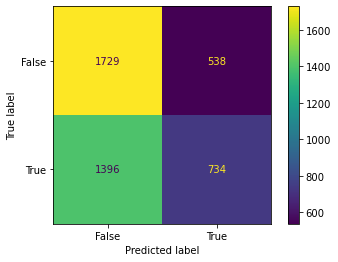

In [106]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = y_test
predicted = preds

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()